# Seasonal Exploration

From Wikipedia:

```
In time series data, seasonality is the presence of variations that occur at specific regular intervals less than a year, such as weekly, monthly, or quarterly. Seasonality may be caused by various factors, such as weather, vacation, and holidays[1] and consists of periodic, repetitive, and generally regular and predictable patterns in the levels of a time series.
```

Seasonality is important to discover because some time series models require either for seasonality to be removed or to be identified.  Many times domain knowledge or simple intuition can tell you if the data contains seasonality.  For example, ice cream sales are higher in the warmer months, whole turkey sales in the US spike around Thanksgiving, and winter jacket sales go up in the colder months.  Even with intuition and/or domain knowledge, having tools which allow you to visualize and detect seasonality is important.

## Setup

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm                                                                                                                          
import statsmodels.formula.api as smf                                                                                                                 
import statsmodels.tsa.api as smt   

%matplotlib inline

/Users/michaelbeale/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#read in the data for average web requests
df = pd.read_csv('data/response_times.csv', index_col=0, parse_dates=True)

In [3]:
df.head()

,value
date,
2017-08-05 14:15:00,13.683435
2017-08-05 14:15:10,14.409674
2017-08-05 14:15:20,14.939440
2017-08-05 14:15:30,15.078855
2017-08-05 14:15:40,15.143022


In [4]:
df.describe()

,value
count,77985.000000
mean,15.865676
std,13.391704
min,10.973009
25%,13.867651
50%,14.698670
75%,15.771283
max,737.892151


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 77985 entries, 2017-08-05 14:15:00 to 2017-08-15 14:57:50
Data columns (total 1 columns):
value    77985 non-null float64
dtypes: float64(1)
memory usage: 1.2 MB


## Visualizing Seasonality

### Simple Plotting

Sometimes the easieast method will work.  Simply plot the data and see if there are any repeating patterns in peaks and/or valleys. 

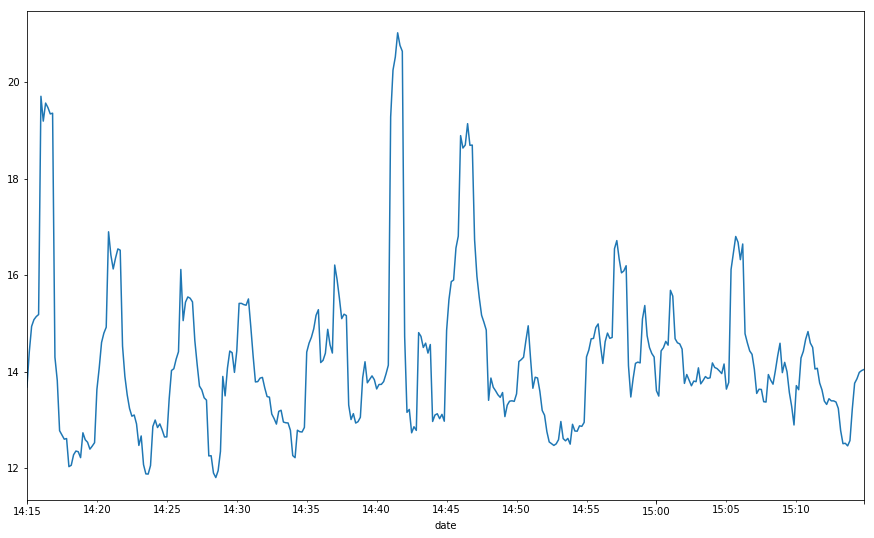

In [6]:
# Using a sub set for the example
# df['value'].plot() would normally work for small set of data
fig = plt.figure(1, figsize=(15, 9))
ax = fig.add_subplot(111)
df.iloc[:360]['value'].plot(ax=ax)

*Summary:* Here there is a recognizable pattern of peaks and valleys in the data.  There appears to be a a peak reached every 5 minutes or so. We could test this theory to see if the seasonality goes away when we resample the data to 5 minutes.

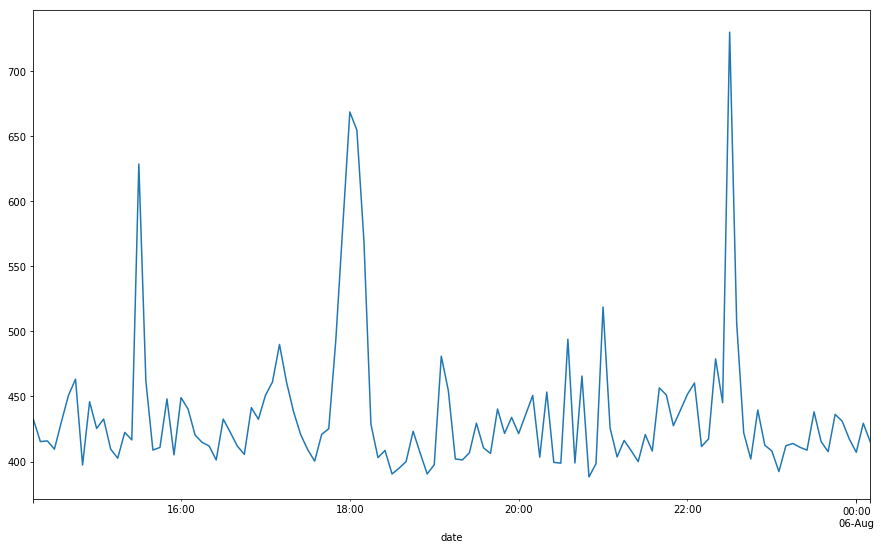

In [7]:
fig = plt.figure(1, figsize=(15, 9))
ax = fig.add_subplot(111)
df.resample('5min').sum().iloc[:120]['value'].plot(ax=ax)

*Summary:* Here the seasonality appears to have been removed and instead we have a series with random noise.

### Seasonal Plotting

Seasonal Plotting can be used to in combination (or standalone) with simple plotting for seasonality discoveries.  The first example will plot 5 minute periods as a separate line to see if the pattern is the same.

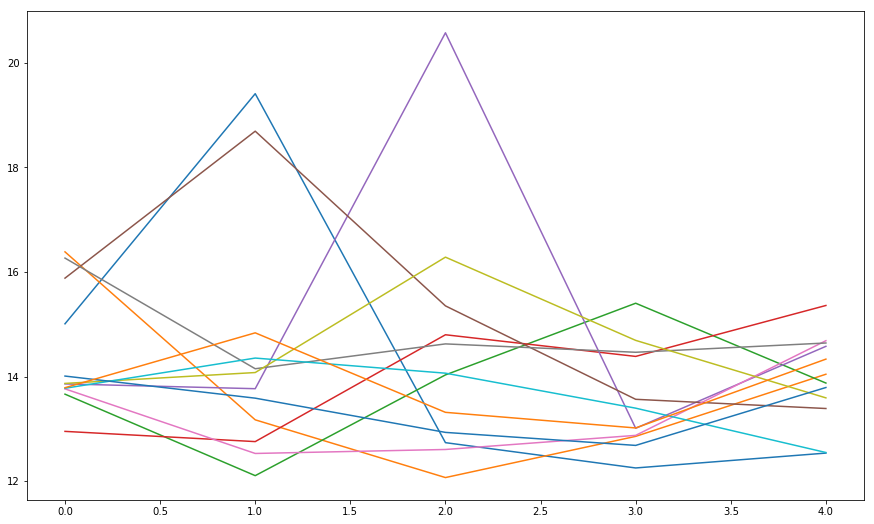

In [8]:
#find the first starting point
ticks = [0, 1, 2, 3, 4]
by_min = df.resample('min').median()
by_min.head()

fig = plt.figure(1, figsize=(15, 9))
ax = fig.add_subplot(111)

#each offset increase by 6 and do 12
for offset in range(0, 72, 6):
    data = [x.value for index, x in by_min.iloc[offset:offset+5].iterrows()]
    ax.plot(ticks, data)
    

*Summary:* There are similarities between the lines but the data has very similar medians so the lines are hard to distinguish.  Lets try a scatter plot.

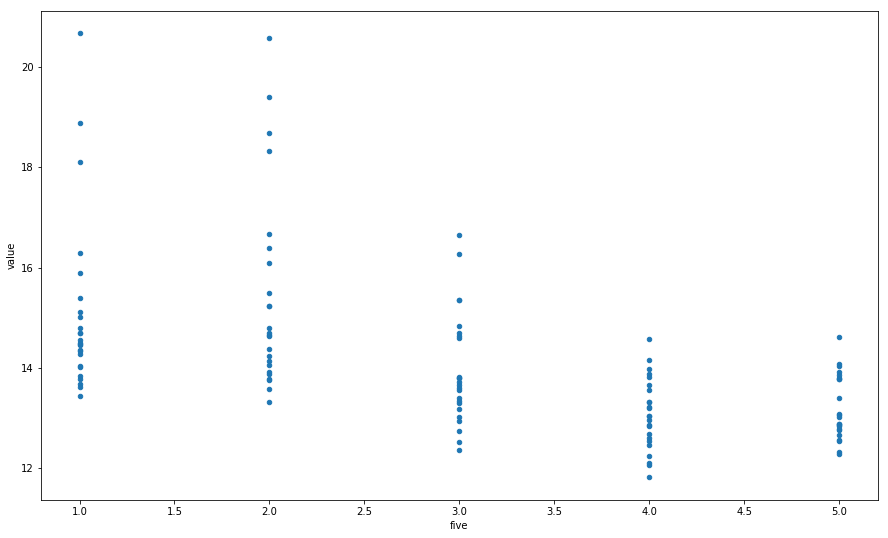

In [9]:
#this function will place the minute in the proper bucket
def group_by_5_minutes(val):
    one = [x for x in range(0, 60, 5)]
    two = [x for x in range(1, 60, 5)]
    three = [x for x in range(2, 60, 5)]
    four = [x for x in range(3, 60, 5)]
    five = [x for x in range(4, 60, 5)]
    
    options = {
        1: one,
        2: two,
        3: three,
        4: four,
        5: five
    }
    
    for i in range(1, 6):
        if val in options[i]:
            return i

fig = plt.figure(1, figsize=(15, 9))
ax = fig.add_subplot(111)
by_min['min'] = by_min.index.minute
by_min['five'] = by_min['min'].apply(group_by_5_minutes)

# Filtering outliers with a value >= 25 to remove any results that will skew the data visualization
by_min[by_min['value'] < 25].iloc[:120].plot(kind='scatter', x='five', y='value', ax=ax)


*Summary:* Here the seasonality can be seen by generating a scatter plot for each minute within a five minute grouping.

### Boxplot method

Using a boxplot can be a quick tool to discover if there are one or more seasonalities in the data.  Since we have data reporting every 10 seconds, we can group by various time periods to see if there are any patterns.  Skipping the plotting of the fliers avoids the charts from getting skewed if there are any fluctuations in the data.

The examples also have the median plotted for an extra visual cue. If the variation in medians are small, seasonality doesn't exist.  If there are no patterns but the sample is small and there are large variations in the data, seasonality exists.

In [10]:
#create columns to group by multiple periods
df['10_second'] = df.index.second
df['minute'] = df.index.minute
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek

#if we had data from a longer time period, we could do monthly or even yearly

df.head(10)

,value,10_second,minute,hour,day_of_week
date,,,,,
2017-08-05 14:15:00,13.683435,0,15,14,5
2017-08-05 14:15:10,14.409674,10,15,14,5
2017-08-05 14:15:20,14.939440,20,15,14,5
2017-08-05 14:15:30,15.078855,30,15,14,5
2017-08-05 14:15:40,15.143022,40,15,14,5
2017-08-05 14:15:50,15.184663,50,15,14,5
2017-08-05 14:16:00,19.703657,0,16,14,5
2017-08-05 14:16:10,19.189270,10,16,14,5
2017-08-05 14:16:20,19.562744,20,16,14,5


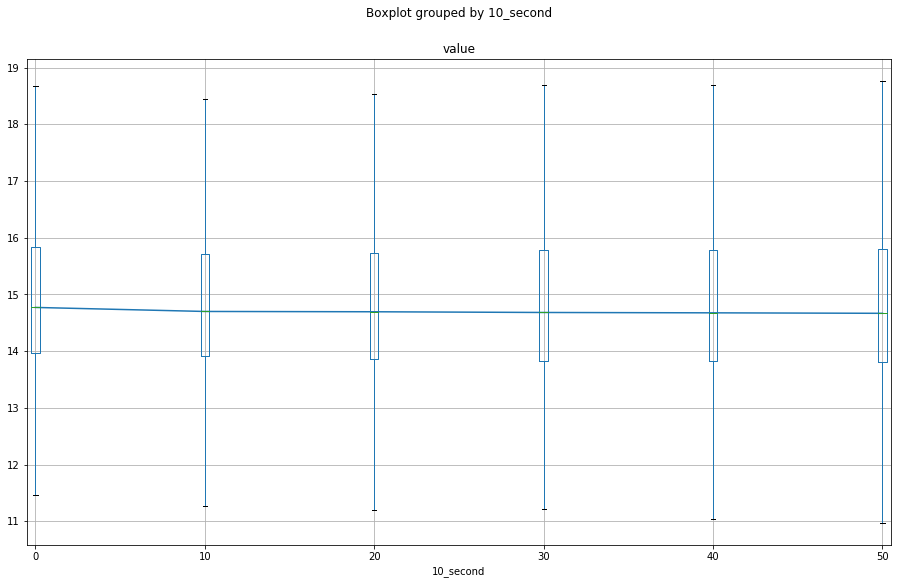

In [11]:
#10 second grouping
fig = plt.figure(1, figsize=(15, 9))
ax = fig.add_subplot(111)
ticks = [x for x in (range(0, 60, 10))]
data = [np.median(df[df['10_second'] == x]['value']) for x in ticks]
ax.plot(ticks, data)
df.boxplot('value','10_second', showfliers=False, ax=ax, positions=ticks)

*Summary*: The median values are almost identical proving that there isn't any seasonality between the 10 second increments.

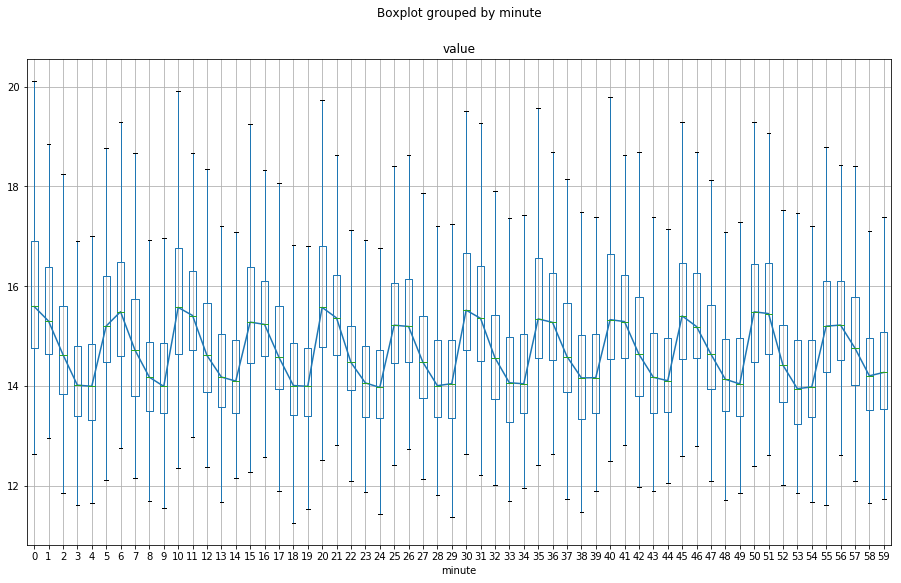

In [12]:
#minute grouping
fig = plt.figure(1, figsize=(15, 9))
ax = fig.add_subplot(111)
ticks = [x for x in (range(60))]
data = [np.median(df[df['minute'] == x]['value']) for x in ticks]
df.boxplot('value','minute', showfliers=False, ax=ax, positions=ticks)
ax.plot(ticks, data)



*Summary*: Here you can clearly see a pattern of data points going up and down in a saw tooth type pattern which would indicate a strong seasonality every 5 minutes.

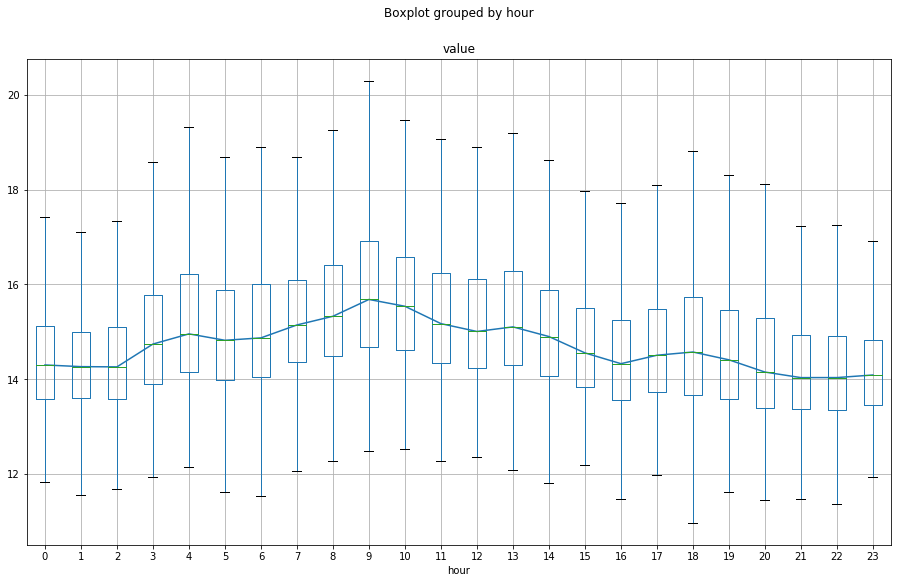

In [13]:
#hour grouping
fig = plt.figure(1, figsize=(15, 9))
ax = fig.add_subplot(111)
ticks = [x for x in (range(24))]
data = [np.median(df[df['hour'] == x]['value']) for x in ticks]
ax.plot(ticks, data)
df.boxplot('value','hour', showfliers=False, ax=ax, positions=ticks)


*Summary:* Here there isn't a noticeable patterns to indicate seasonality.  We should check the variance. 

In [14]:
std = np.std(data)
mean = np.mean(data)
print("{} / {} = {}".format(std, mean, (std/mean)))

0.4698394786808777 / 14.700139320690937 = 0.03196156637914057


Since the variance coefficient is very low, seasonality doesn't exist for the hourly grouping.  Typically a coefficient < 1 is generally considered low.

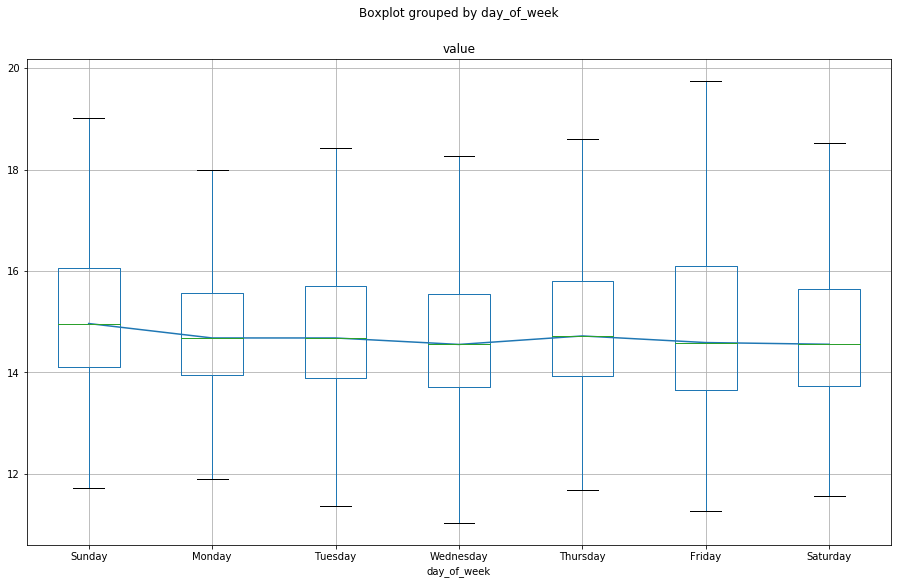

In [15]:
#day of week grouping
fig = plt.figure(1, figsize=(15, 9))
ax = fig.add_subplot(111)
ticks = [x for x in (range(7))]
data = [np.median(df[df['day_of_week'] == x]['value']) for x in ticks if len(df[df['day_of_week'] == x]) > 0]
#in case not all days exist
ticks = [x for x in (range(len(data)))]
ax.plot(ticks, data)
df.boxplot('value','day_of_week', showfliers=False, ax=ax, positions=ticks)
ax.set_xticklabels(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])


*Summary:* Not much fluctuation here.

## Scatter plot matrix method

Using a scatter plot can be a simple way of visualizing a point relates to it's lag.

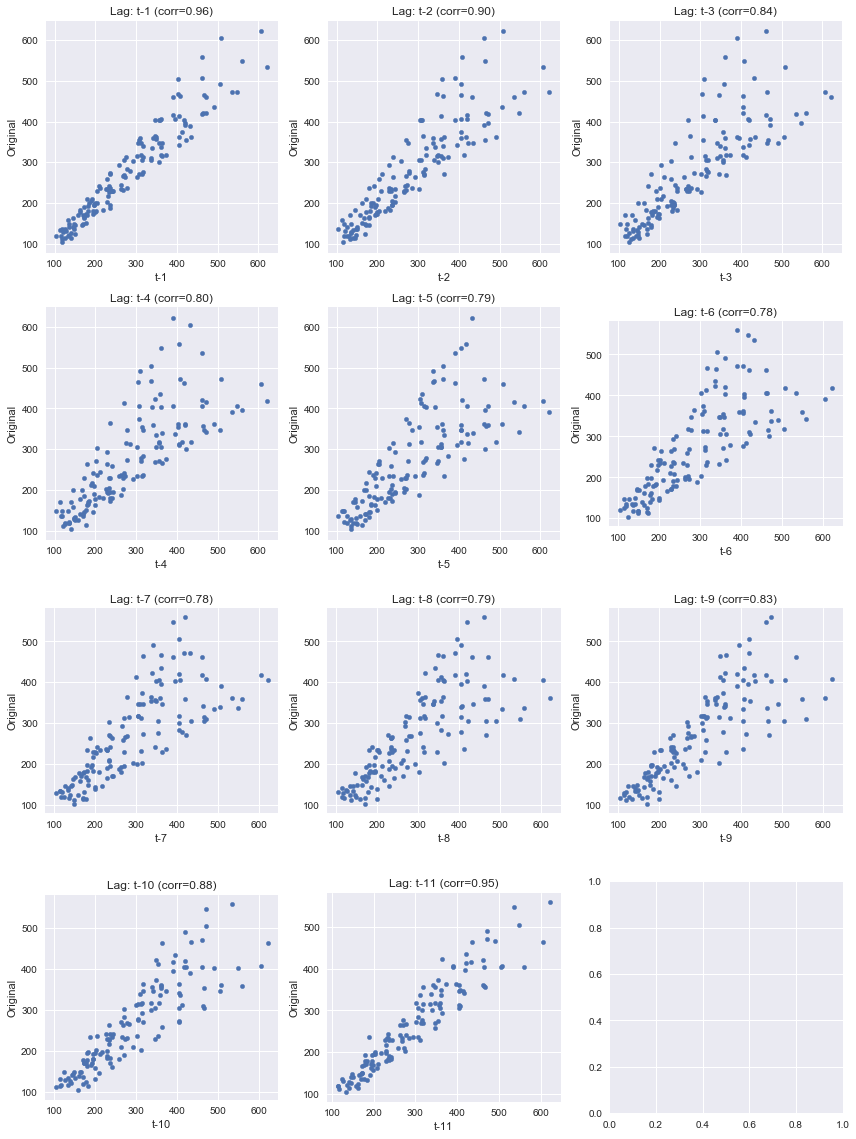

In [21]:
air = pd.read_csv('data/international-airline-passengers.csv', header=0, index_col=0, parse_dates=[0])

lags=11

ncols=3
nrows=int(np.ceil(lags/ncols))

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 4*nrows))

for ax, lag in zip(axes.flat, np.arange(1,lags+1, 1)):
    lag_str = 't-{}'.format(lag)
    X = (pd.concat([air, air.shift(-lag)], axis=1,
                   keys=['y'] + [lag_str]).dropna())

    X.plot(ax=ax, kind='scatter', y='y', x=lag_str);
    corr = X.corr().as_matrix()[0][1]
    ax.set_ylabel('Original')
    ax.set_title('Lag: {} (corr={:.2f})'.format(lag_str, corr));
    ax.set_aspect('equal');
    sns.despine();

fig.tight_layout();

A straight line from the bot left to the top right would indicate a strong correlation.  The closer the grouping to that line, the more correlated that data is.  In this example, you can see the correlations vary from lag to lag with a high correlation on the t-11 which would indicate a seasonality of 12 months.

### Autocorrelation Function (ACF)

Autocorrelation measures how a time series point correlates to other points(lags) in the series.  This can be useful to inspect if there is seasonality in the data. 

In [7]:
# monthly international airline data
air = pd.read_csv('data/international-airline-passengers.csv', header=0, index_col=0, parse_dates=[0])

(0, 63.0)

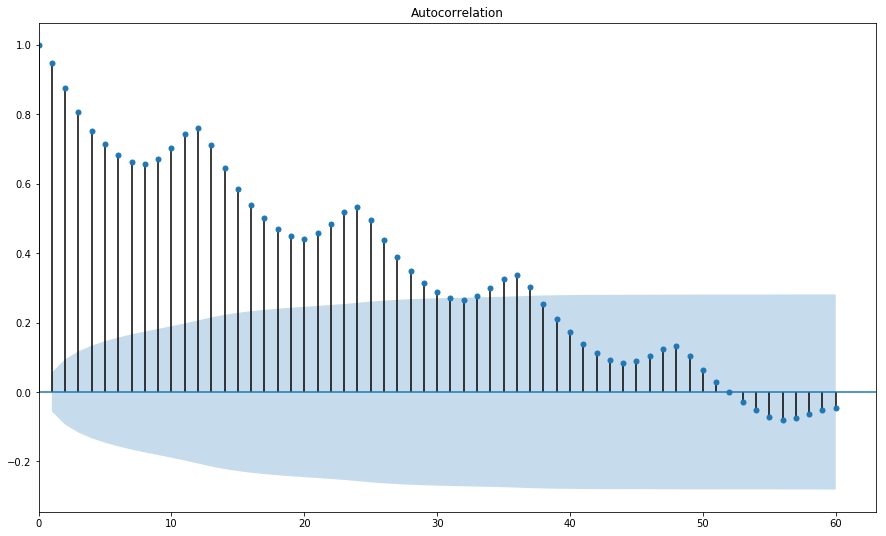

In [8]:
fig = plt.figure(1, figsize=(15, 9))
ax = fig.add_subplot(111)
smt.graphics.plot_acf(air, lags=60, ax=ax, alpha=0.5)
#remove chart duplication
ax.set_xlim(0)

*Summary:*  The ACF clearly indicated a pattern every 12 months (expected for monthly seasonal data).  The blue area represents the 95% confidence interval.

### Seasonal Indicies

*Coming Soon*

### Periodogram

This uses a Fourier transform function to display periodogram.

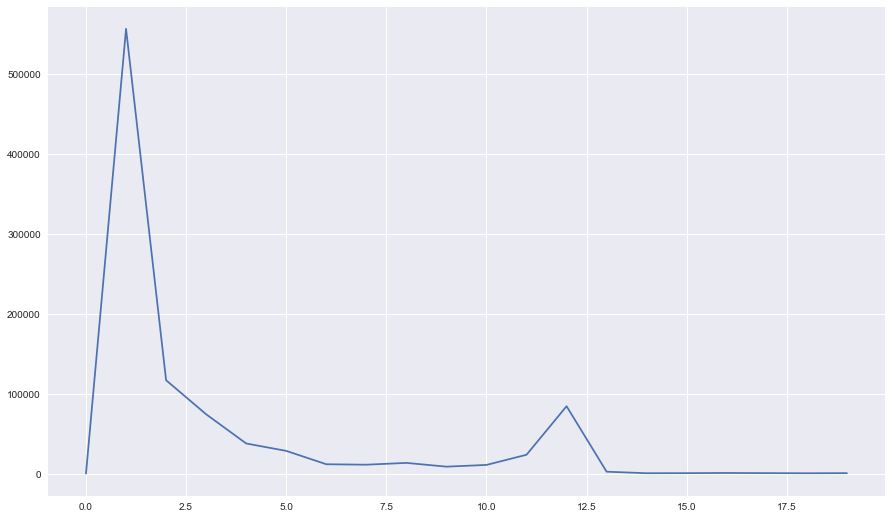

In [3]:
air = pd.read_csv('data/international-airline-passengers.csv', header=0, index_col=0, parse_dates=[0])

fig = plt.figure(1, figsize=(15, 9))
ax = fig.add_subplot(111)
ax.plot(smt.periodogram(air['n_pass_thousands'])[:20])  # just showing the first 20 periods

Here you can see that around 12, there is a spike indicating a period there.